# CIS 530 Fall 2020 Homework 6

Before you turn this notebook in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel → Restart) and then run all cells (in the menubar, select Cell → Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Matthew Scharf"
PENNKEY = "81364044"
RECITATION = "3"

---


# CIS 530 Homework 6: Neural Language Models


In this assginment, we’ll be moving on from traditional n-gram based language models to more advanced forms of language modeling using neural networks. Specifically, we’ll be setting up a character-level recurrent neural network, known as a char-rnn for short.


Andrej Karpathy, previously a researcher at OpenAI, has written an excellent blog post [*The Unreasonable Effectiveness of Recurrent Neural Networks*](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) about using RNNs for language models. You should read before beginning this assignment.  


Karpathy shows how char-rnns can be used to generate texts for several fun domains:

*   Shakespeare plays
*   Essays about economics
*   LaTeX documents
*   Linux source code
*   Baby names


In this assignment you will follow a PyTorch tutorial to implement your own char-rnn, and then test it on a dataset of your choice. 



**Note**: Please look at the [FAQ](https://piazza.com/class/kdaawimt6bj7nn?cid=365) section on Piazza before you start working. 

To submit on Gradescope, go to ***File -> Download .ipynb*** and ***File -> Download .py***. Upload both of the ***.ipynb*** and ***.py*** files to Gradescope. 

## Section 0: Preamble and Setup

PyTorch is one of the most popular deep learning frameworks in both industry and academia, and learning its use will be invaluable should you choose a career in deep learning. You will be using PyTorch for this assignment, we ask you to build off a couple PyTorch tutorials.

### Section 0.1: About PyTorch

PyTorch abstracts the back-propogation process from us, allowing us to define neural network structures and use a generic .backward() function to compute the gradients that are later used in gradient descent (PyTorch also implements such optimization algorithms for us).

<img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif" alt="dynamic graph">


PyTorch does all of this for us by maintaining a computational graph, which allows differentiation to happen automatically! Don’t worry if you don’t remember your chain rules from MATH 114. Another nice thing about PyTorch is that it makes strong use of both object-oriented and functional programming paradigms, which makes reading and writing PyTorch code very accessible to previous programmers.

### Section 0.2: Google Colab Set-Up

Go to ***Runtime -> Change runtime type*** and set hardware accelerator to GPU. Run the following cell to set up the environment and download the dataset. You DO NOT need to modify it. Note that it might take a couple of minutes for this cell to finish running. 

In [ ]:
#Download and unzip files
!pip3 install scikit-learn
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip 
!unzip cities_train.zip 
from os.path import exists
!pip install "wheel==0.34.2"
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch

--2020-12-03 18:03:48--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10973 (11K) [text/plain]
Saving to: ‘cities_test.txt’

cities_test.txt     100%[===================>]  10.72K  --.-KB/s    in 0s      

2020-12-03 18:03:48 (250 MB/s) - ‘cities_test.txt’ saved [10973/10973]

--2020-12-03 18:03:48--  http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
Resolving computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
Connecting to computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7558 (7.4K) [application/zip]
Sav

You DO NOT need to modify the following cell. It verifies the downloaded datasets. To view the datasets, click on the ***Files*** icon in the vertical toolbar on the left. 

In [ ]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verify CUDA acceleration should print cuda:0
print(device)

cpu


In [ ]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"

garavshakh
kalishli
sarban kelay
dahan-e surunah
jahannum
morafeno
iskatel
zeri-chinar
taftebole
dzhafarabat

sikhtopa
laferronay
cham ghafur
souk tafetecht
panqash
siah sar bala
barah khan kili
vetob
kacari
kolga'i-i-bala

imam bakhsh amar
firoz laghari
glufishevo
qal`eh-ye ghazanfarkhani
nikolinalevada
kolkko
mbrostar i fierit
kharabanan-e sofla
stein bei nurnberg
jahangir bara



Mount your Google drive to this notebook. Use this to save your PyTorch models for submission. Feel free to change the saving directory to the appropriate location in your drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir /content/gdrive/MyDrive/Colab\ Notebooks/cis530_hw6

#Test drive access. 
#You should have a test.txt under a new folder cis530_hw6 in your Google drive
with open('/content/gdrive/MyDrive/Colab Notebooks/cis530_hw6/text.txt', 'w') as f:
  f.write('This is a test!')

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/MyDrive/Colab Notebooks/cis530_hw6’: File exists


## Section 1: Character-Level Recurrent Neural Networks



###1.1 Follow the tutorial code


Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify baby names by their country of origin. It is recommended that you can reproduce the tutorial’s results on the provided baby name dataset before moving on, since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

###1.2 Switch to city names dataset

Modify the tutorial code to instead read from the city names dataset that we used in the previous assignment. The tutorial code problematically used the same text file for both training and evaluation. We learned in class about how this is not a great idea. For the city names dataset we provide you separate train and validation sets, as well as a test file.

All training should be done on the train set and all evaluation (including confusion matrices and accuracy reports) on the validation set. You will need to change the data processing code to get this working. In addition, to handle unicode, you might need to replace calls to `open` with calls to `codecs.open(filename, "r",encoding='utf-8', errors='ignore')`.

**Warning**: you’ll want to lower the learning rating to 0.002 or less or you might get NaNs when training.

**Note**: In the following two cells, we provide you the skeleton code to build a Char-RNN classifier. Please read the signitures of each functions below carefully and stick with them so that the autograder will work as expected. Pay special attention to the desired output!



In [ ]:
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F

'''
Please add default values for all the parameters of __init__.
'''
import torch.nn as nn

class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
  

In [ ]:
import os
import re
import copy
import codecs
import math
import random
import string
import time
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
def getWords(baseDir, lang, train = True):
    if train:
      dir = 'train'
    else:
      dir = 'val'

    with codecs.open(baseDir  + '/' + dir + '/' + lang + '.txt', 
                "r",
                encoding='utf-8', 
                errors='ignore') as f:
        lines = f.read().strip().split('\n')
    
    def filter(str_):
      return ''.join([i for i in str_ if i in all_letters])
    
    return np.array(list(map(filter,lines))).reshape(-1,1)
     
'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    return languages.index(lang) * np.ones((length,1))

'''
Returns all the languages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    X_list = []
    y_list = []
    
    for lang in languages:
      new_words = getWords(baseDir, lang, train = train)
      X_list.append(new_words)
      y_list.append(getLabels(lang, len(new_words)))
    
    X = np.concatenate(X_list)
    y = np.concatenate(y_list)
  
    return X, y




'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    # NOTE!: Pay attention to the shape of the returned tensor! The shape should be <line_length x 1 x n_letters>,
      tensor = torch.zeros(len(line), 1, len(all_letters))
      for li, letter in enumerate(line):
          try:
            tensor[li][0][all_letters.index(letter)] = 1
          except ValueError:
            print(letter)
            raise ValueError
      return tensor

'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    lang_idx = int(torch.argmax(output))
    lang = languages[lang_idx]
    return lang, lang_idx
'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def random_training_pair(X, y):
  rand_idx = random.randint(0, len(X) - 1)
  city = X[rand_idx][0]
  city_tensor = line_to_tensor(city)
  label_tensor = torch.tensor([y[rand_idx][0]], dtype=torch.long)
  return city_tensor, label_tensor

'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
@torch.no_grad()
def predict(model, X, y):
    def get_output(line):
      line_tensor = line_to_tensor(line).to(device)
      hidden = model.initHidden().to(device)
      for i in range(len(line)):
          output, hidden = model(line_tensor[i], hidden)
      _, lang_idx = category_from_output(output)
      return lang_idx
    
    return list(map(get_output,X.flatten()))

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    pred = predict(model, X, y)
    return accuracy_score(y, pred)

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    
    city_tensor, label_tensor = random_training_pair(X, y)

    city_tensor = city_tensor.to(device)
    label_tensor = label_tensor.to(device)

    hidden = model.initHidden().to(device)
    optimizer.zero_grad()

    for i in range(city_tensor.size()[0]):
        output, hidden = model(city_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()
    optimizer.step()

    return model, output, loss.item(), city_tensor, label_tensor.item(), optimizer

@torch.no_grad()
def getValLoss(model, X_val, y_val, criterion):
    loss_list = []

    for line, label in zip(X_val.flatten(),y_val.flatten()):
      line_tensor = line_to_tensor(line).to(device)
      label_tensor = torch.tensor([label], dtype=torch.long).to(device)
      
      hidden = model.initHidden().to(device)
      for i in range(len(line)):
          output, hidden = model(line_tensor[i], hidden)
      
      loss = criterion(output, label_tensor).item()
      loss_list.append(loss)
    
    avg_loss = np.mean(loss_list)
    
    return avg_loss

'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
def run(hidden=128,lr=.0005, epochs=100000, display_progress=False,baseDir='/content',break_thresh=.12):

  loss_list = []
  corr_count = []
  val_acc_list = []
  val_loss_list = []

  criterion = nn.NLLLoss()
  X, y = readData(baseDir, train=True)

  X_val, y_val = readData(baseDir, train=False)

  model=CharRNNClassify(len(all_letters),hidden,len(languages))
  model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  for i in range(epochs+1):
    
    if i % 1000 == 0:
      
      val_acc = calculateAccuracy(model, X_val, y_val)

      val_loss = getValLoss(model, X_val, y_val, criterion)
      
      if val_acc_list[-1]>break_thresh+.1 and val_acc < break_thresh:
        print("Model overtrained and become degenerate-aborting and reverting to 1000 epochs earlier")
        model = model_backup
        val_acc = val_acc_list[-1]
        val_loss = val_loss_list[-1]
        loss_list = loss_list[:-1000]
        corr_count = corr_count[:-1000]
        break

      val_acc_list.append(val_acc)
      val_loss_list.append(val_loss)
      model_backup = copy.deepcopy(model)

      if display_progress:
        print("Epoch:",i)
        print("Validation Accuracy:",val_acc)
        print("Validation Loss:",val_loss)
        print('\n')

    model, output, loss, _, label, optimizer = trainOneEpoch(model, criterion, optimizer, X, y)
    _, pred = category_from_output(output)
    
    corr_count.append(int(pred==label))

    loss_list.append(loss)
  
  print("Final Validation Accuracy:",val_acc)
  print("Final Validation Loss:",val_loss)
  
  def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

  
  pred = predict(model, X_val, y_val)
  hmap = pd.DataFrame(confusion_matrix(y_val, pred),
                    index=languages,
                    columns=languages)
  sns.heatmap(hmap, annot=True)
  plt.show()

  smoothing_factor = 1000
  model.eval()
  torch.save(model.state_dict(), "/content/myModel")

  loss_smoothed = moving_average(loss_list, n=smoothing_factor)
  acc = moving_average(corr_count, n=smoothing_factor)

  plt.plot(list(range(len(loss_smoothed))),loss_smoothed,label='Training')
  plt.plot(list(range(0,1000*len(val_loss_list),1000)),val_loss_list,label='Validation')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Average Surprisal')
  plt.legend(loc='best')
  plt.show()
  plt.close()

  plt.plot(list(range(len(acc))),acc,label='Training')
  plt.plot(list(range(0,1000*len(val_acc_list),1000)),val_acc_list,label='Validation')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show()

  return model

  


  
    

###1.3 Experimentation and Analysis

Complete the following analysis on the city names dataset, and include your finding in the cell below.

1.  Write code to output accuracy on the validation set. Include your best accuracy in the report. (For a benchmark, the TAs were able to get accuracy above 50% without any hyperparameter optimization) Discuss where your model is making mistakes. Use a confusion matrix plot to support your answer.

2.  Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses. Is your model overfitting? Include the plot in your report.

3.  Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss.

4.  Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy?

Below I run the training 9 times: each combination of hidden size in [32, 64,128 ] and learning rate in [.0005, .001, .002]. For each run, I ran for 250,000 epochs and plotted the accuracies and losses over time. I also included confusion matrices.

Parameters: num epochs=250000, learning rate=0.0005, hidden size=32
Final Validation Accuracy: 0.4311111111111111
Final Validation Loss: 1.6499535184436374


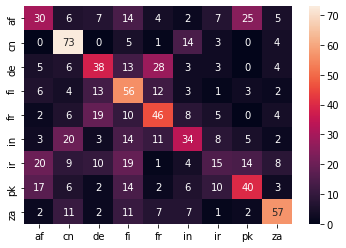

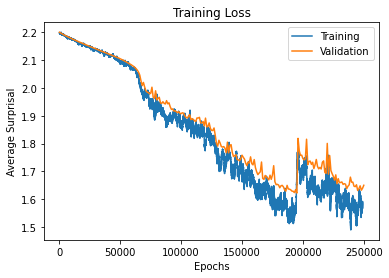

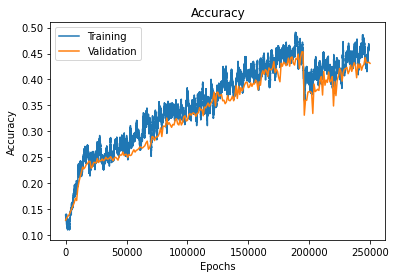

Parameters: num epochs=250000, learning rate=0.001, hidden size=32
Final Validation Accuracy: 0.4622222222222222
Final Validation Loss: 1.5775657917393577


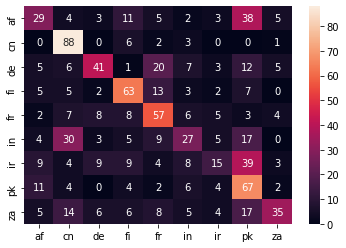

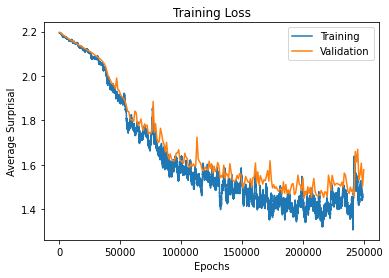

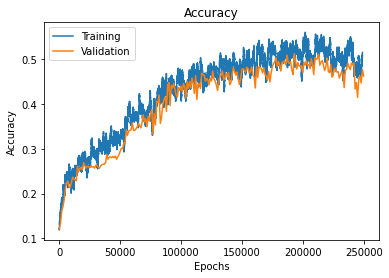

Parameters: num epochs=250000, learning rate=0.002, hidden size=32
Final Validation Accuracy: 0.45111111111111113
Final Validation Loss: 1.5634418670336405


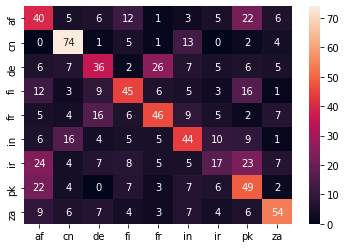

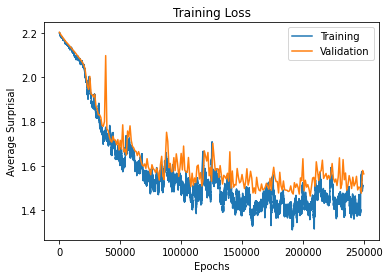

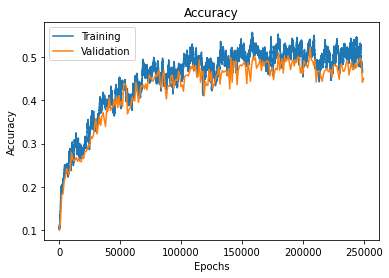

Parameters: num epochs=250000, learning rate=0.0005, hidden size=64
Final Validation Accuracy: 0.4222222222222222
Final Validation Loss: 1.653046298291948


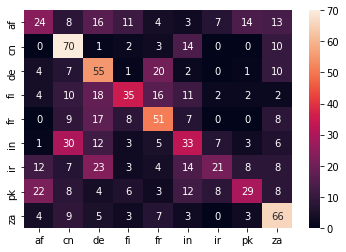

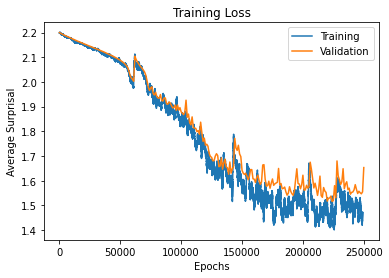

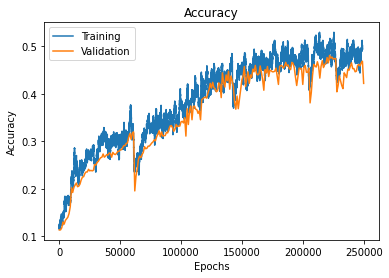

Parameters: num epochs=250000, learning rate=0.001, hidden size=64
Final Validation Accuracy: 0.5088888888888888
Final Validation Loss: 1.4601392430729336


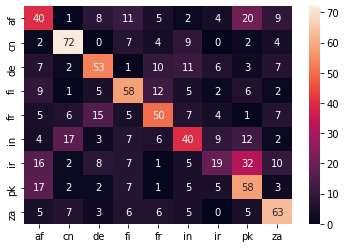

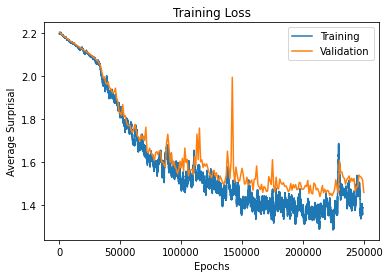

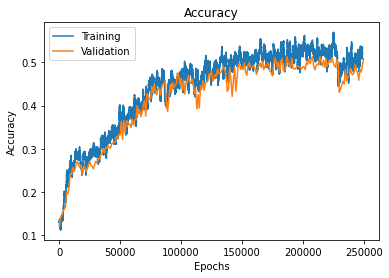

Parameters: num epochs=250000, learning rate=0.002, hidden size=64
Model overtrained and become degenerate-aborting and reverting to 1000 epochs earlier
Final Validation Accuracy: 0.4866666666666667
Final Validation Loss: 1.4935086537732019


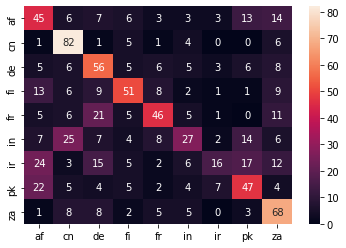

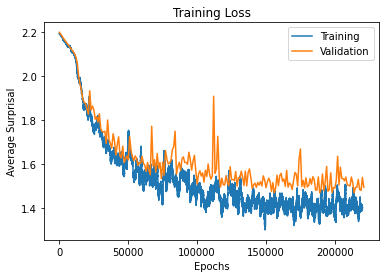

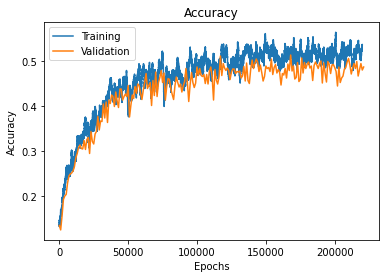

Parameters: num epochs=250000, learning rate=0.0005, hidden size=128
Final Validation Accuracy: 0.5077777777777778
Final Validation Loss: 1.4777408587932586


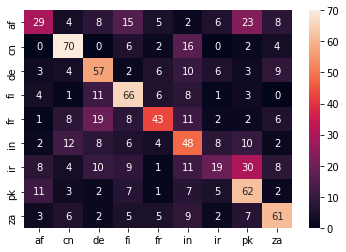

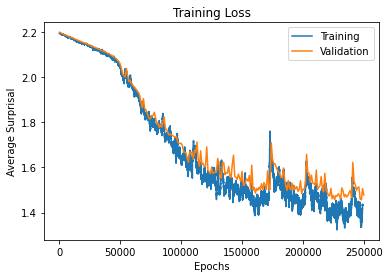

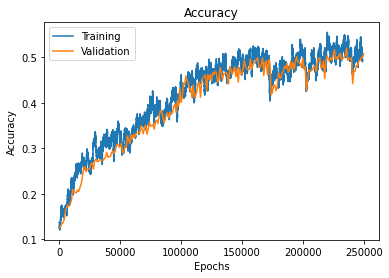

Parameters: num epochs=250000, learning rate=0.001, hidden size=128
Final Validation Accuracy: 0.5144444444444445
Final Validation Loss: 1.445699964761734


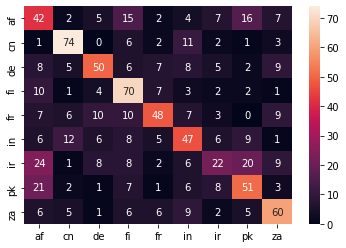

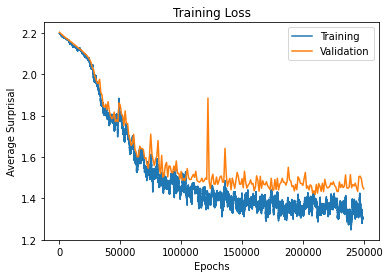

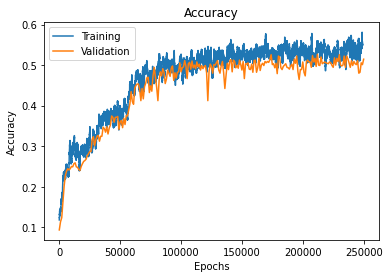

Parameters: num epochs=250000, learning rate=0.002, hidden size=128
Final Validation Accuracy: 0.4666666666666667
Final Validation Loss: 1.56620263894399


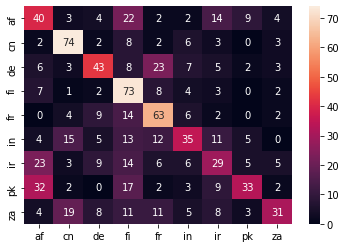

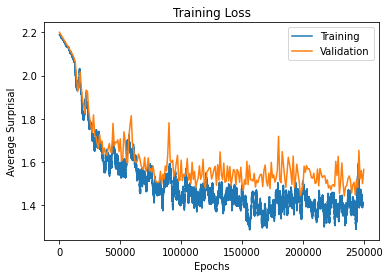

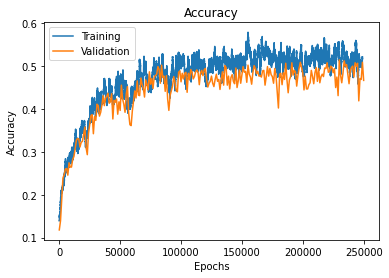

In [ ]:
num_epochs = 250000
hidden_size_list = [32,64,128]
learning_rate_list = [.0005,.001,.002]
for hidden_size in hidden_size_list:
  for lr in learning_rate_list:
    print("Parameters: num epochs={}, learning rate={}, hidden size={}"\
          .format(num_epochs, lr,hidden_size))
    model = run(hidden = hidden_size,lr = lr,epochs=num_epochs,display_progress=False)

# Report

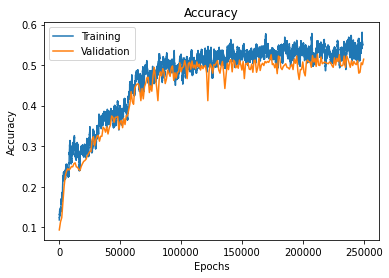

The configuration of learning rate=0.001 and hidden size=128 achieved the highest final accuracy. It achieved a final validation accuracy of 0.514 and a final validation loss of 1.45.

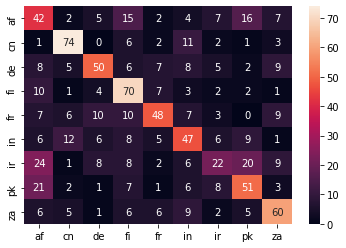

Now looking at the confusion matrix associated with the highest accuracy, the countries with the highest accuracies are China and Finland with .74 and .70 recall respectively. The country which was most often wrongly guess was Iran which had a recall of only .22. 

The country pairs which were most often confused were (Iran, Pakistan), (Iran, Afghanistan), and (Pakistan, Afghanistan). This makes sense because these countries all border each other. 

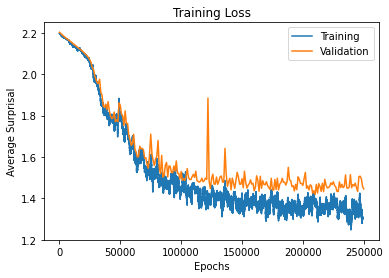

It seems as though the model is not overfitting for the first 100,000 epochs because the training loss and validation decrease together. After 100,000 epochs, the training loss dips a little below the validation loss, indicating a bit of overfitting, but it doesn't seem to have a detrimental effect on the validation loss as it remains relatively constant.

Of the three choices of learning rates: [.0005, .001, .002] .001 achieved the highest validation accuracy across all three different hidden layer sizes. This tells me that .001 is likely the best choice of learning rate. Between .0005 and .002, it is interesting to note that .001 performed better on the smallest hidden layer size of 32 and .0005 performed better on the largest hideen layer size of 128. This is as we would expect: smaller learning rates are better for more complicated architectures.

As for the hidden layer sizes, across [32, 64, 128] in general the larger the layer size, the better the accuracy. This indicates to me that I was likely on the lower end of sizes and maybe it would be interesting to try 256. It might also be interesting to see if a learning rate of .0005 fares better than .001 on a hidden layer size of 256.








##Section 2: Text Generation

In this section, you will be following more PyTorch tutorial code in order to reproduce Karpathy’s text generation results. Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) to get an understanding for the neural architecture, and then download the iPython notebook from this [repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-generation) to base your own code on (it’s a bit easier to follow than the former).

You will notice that the code is quite similar to that of the classification problem. The biggest difference is in the loss function. For classification, we run the entire sequence through the RNN and then impose a loss only on the final class prediction. For the text generation task, we impose a loss at each step of the RNN on the predicted character. The classes in this second task are the possible characters to predict.

###2.1 Experimenting with your own dataset

Be creative! Pick some dataset that interests you. Here are some ideas:


*   [ABC music format](https://raw.githubusercontent.com/rdeese/tunearch-corpus/master/all-abcs.txt)
*   [Webster dictionary](http://www.gutenberg.org/cache/epub/29765/pg29765.txt)
*   [Jane Austen novels](http://www.gutenberg.org/files/31100/31100.txt)



# Building a text generation model for Jane Austen

In [ ]:
from os.path import exists
!pip install "wheel==0.34.2"
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verify CUDA acceleration should print cuda:0
print(device)

cuda:0


In [ ]:
!wget "http://www.gutenberg.org/files/31100/31100.txt"
!pip install unidecode
import unidecode
import string
import random
import re

--2020-12-04 01:36:40--  http://www.gutenberg.org/files/31100/31100.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4454075 (4.2M) [text/plain]
Saving to: ‘31100.txt.4’

31100.txt.4         100%[===================>]   4.25M  1.11MB/s    in 4.3s    

2020-12-04 01:36:45 (1001 KB/s) - ‘31100.txt.4’ saved [4454075/4454075]



In [ ]:
import numpy as np

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)


with open('31100.txt', encoding='utf-8', errors='ignore') as f:
    file = unidecode.unidecode(f.read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4373592


In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ow can you say so? How can you be so
unjust? They are a very respectable family, Mr. Ferrars; and towards
us have behaved in the friendliest manner. Have you forgot, Marianne,
how many pleasant days we


In [ ]:
# Build the Model

#This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor).reshape(-1,1)

print(char_tensor('abcDEF'))

tensor([[10],
        [11],
        [12],
        [39],
        [40],
        [41]])


In [ ]:
#Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1]).to(device)
    target = char_tensor(chunk[1:]).to(device)
    return inp, target

In [ ]:
# Evaluating

#To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().to(device)
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1].to(device)
    hidden = hidden.to(device)

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        hidden = hidden.to(device)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).to(device)

    return predicted

In [ ]:
# Training

#A helper to print the amount of time passed:

import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#The main training function

def train(inp, target):
    hidden = decoder.init_hidden().to(device)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len
@torch.no_grad()
def get_perp(given_text):
    iters = len(given_text)-1
    hidden = decoder.init_hidden().to(device)
    text_tensor = char_tensor(given_text).to(device)

    loss = 0
    for c in range(iters):
        output, hidden = decoder(text_tensor[c], hidden)
        hidden = hidden.to(device)
        loss += criterion(output,text_tensor[c+1])

    return np.exp(loss.item() / iters)

In [ ]:
n_epochs = 10000
print_every = 1000
plot_every = 100
hidden_size = 128
n_layers = 1
lr = 0.0005

In [ ]:
#Then we define the training parameters, instantiate the model, and start training:

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder.to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 49s (1000 10%) 2.0015]
Whis. The lat. Cdrough have listeytis he the lesse to has liming she you lestecter in you somest dishe 

 39s (2000 20%) 1.7850]
Wht Prowas to lighter as allone wom fereen's lexcess and have hive releft Compiling and, and the may p 

 30s (3000 30%) 2.4473]
Whet, by own was mame to be of your of her doned it, and the can ay yeen into desting this
in to felie 

 19s (4000 40%) 1.6377]
Wh, to devery to have she had would  Elingain. I disharded to partungs
one was any mele:
on the with f 

 9s (5000 50%) 1.6846]
Wher much that Manne the distal which
compleded her refections, are of doour Mr. Ellined from my as su 

 59s (6000 60%) 1.5322]
What it down. And where object, or speak a
dreable to her eliness to be which has it was age famaines  

 49s (7000 70%) 1.5132]
Whe was
sightly will gave that the complia to her
impain comfort of given, and been enjected, staked t 

 39s (8000 80%) 1.8440]
Wher to that I tirely spooks to great sure a better most speation of once 

In [ ]:
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder.load_state_dict(torch.load("/content/myGenerationModel.pt"))
decoder.to(device)

RNN(
  (encoder): Embedding(100, 128)
  (gru): GRU(128, 128)
  (decoder): Linear(in_features=128, out_features=100, bias=True)
)

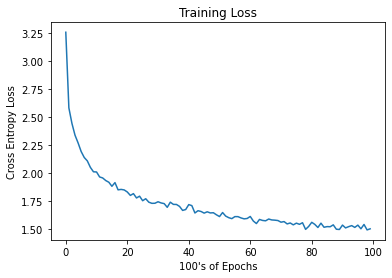

In [ ]:
# Plotting the Training Losses

#Plotting the historical loss from all_losses shows the network learning:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.title('Training Loss')
plt.xlabel("100's of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(all_losses)
plt.show()

###2.2 Results and Analysis

In your report, include a sample of the text generated by your model, and give a qualitative discussion of the results. Where does it do well? Where does it seem to fail? Report perplexity on a couple validation texts that are similar and different to the training data. Compare your model’s results to that of an n-gram language model.

Here I generate text using the model. The generated text seems to emulate Jane Austen at a local level (words and phrases) but seems unable to create meaningful structure for much longer than a few words. That being said, at a local level you can definitely see some semblance of themes and word from Jane Austen like "she had been evening", "Miss Walked to might complain", and "little can sister".

In [ ]:
evaluate('The', 400,temperature=.5)

'There was a man was a cried herself of the few was\nan enough of her see Harriet Harriet was not is not sister, and the same is from the to that Miss Walked to might complain to sefter a more the imposed to the proper with such a first stay as she had been evening all the sumple to make it, and a little can sister of his was all the counting its particular to the could not be some a trach for the amon'

Here I calculate perplexity of several sentences using the model. The first is a quote from Jane Austen in the training set and the next three are the sentences I evaluated with my n-gram model in HW #4. 

In [ ]:
#Text from Jane Austen book
get_perp("It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.")

4.387863810354625

The Jane Austen sentence has the lowest perplexity as we would expect because it was in the training set.

In [ ]:
#Quote from "Back to the Future"
get_perp("why don't you make like a tree and get outta here")

7.245097716125841

The quote from "Back to the Future" has the second lowest perplexity because it is modern English and Jane Austen is (fairly) modern English. Note that the perlexity here (7.2) is lower than the perplexity in the Shakespeare n-gram language model (12.44). This is likely because the English in "Back to the Future" is closer to Jane Austen than Shakespeare.

Also, neural models are more forgiving of deviations from the training set than n-gram models because they extrapolate more and put less emphasis on having seen the example before (e.g. more smoothing). This results in a lower perplexity for less familiar texts than a similar n-gram model.

In [ ]:
#Modern text which was converted to "Shakespearean form" by an online program
get_perp('prepareth to square i shall heave the gorge on thy livings naughty mushrump')

9.6105842288411

The Shakespearized text has the next lowest perplexity because it is vaguely english, although a fairly different form of English. It actually has a slightly lower perplexity here than in the shakespeare model (9.6 to 10.4) which I attribute primarily to the increased smoothing phenomenon described above.

In [ ]:
#Pseudo-randomly generated text (from keyboard mashing)
get_perp('fjkfwifailwefbaneifg erg u ugb rb ndavba')

354.85247698105223

The randomized text has the highest perplexity as we would expect as it is not English (or any language) at all. In fact, the perplexity should be close the size of the vocabulary (or would be if the text was infinitely long and actually generated randomly). 

##Section 3: WHAT TO SUBMIT

To submit on Gradescope, go to ***File -> Download .ipynb*** and ***File -> Download .py***. Then, click on the ***Files*** icon in the vertical toolbar on the left. Navigate to the relevant folder in your Google Drive. Right click on your saved model for the classification task, named `myModel.pt` and download it. Right click on your saved model for the generation task, named `myGenerationModel.pt` and download it. Make sure the file names are exactly as below. That is, please remove any "copy of" or "(1)" that may appear in the filename. Finally, upload to Gradescope:

1.   cis_530_homework_6.ipynb
2.   cis_530_homework_6.py
3.   myModel.pt
4.   myGenerationModel.pt
